<a href="https://colab.research.google.com/github/natiska/ai4trees-height/blob/main/notebooks/Natalia/create_tiles_with_new_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install geojson -qq
!pip install wandb -qq

In [32]:
import geojson
import numpy as np
import os
import gdal
import matplotlib.pyplot as plt
from matplotlib.path import Path

In [8]:
from google.colab import auth
auth.authenticate_user()

In [9]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
FULL_DATA_PATH = "/content/drive/MyDrive/AI for Trees Share/Data to be Labeled"
OUTPUT_PATH = "/content/drive/MyDrive/AI for Trees Share/01. Data/tiles_with_improved_labels"

In [24]:
ex_file = "ZK21"

In [13]:
with open(FULL_DATA_PATH+"/labels/" + ex_file + ".geojson") as f:
    gj = geojson.load(f)

In [28]:
img_path = os.path.join(FULL_DATA_PATH, "img", ex_file+".tif")
img_array = gdal.Open(img_path).ReadAsArray()
img_array = np.swapaxes(np.swapaxes(img_array,0,2),0,1)

In [29]:
img_array.shape

(2319, 5012, 4)

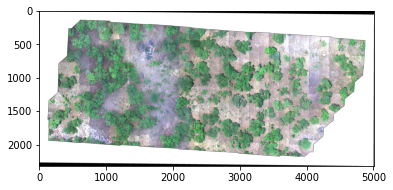

In [30]:
plt.imshow(img_array)

In [21]:
def prepare_mask(tile_name, tiles_path, add_bboxes=False, show_image_in_background=False):
  img_path = os.path.join(tiles_path, "img", tile_name+".tif")
  with open(os.path.join(tiles_path, "labels", tile_name+".geojson")) as f:
    gj = geojson.load(f)
  img_array = gdal.Open(img_path).ReadAsArray()
  if len(list(img_array.shape)) == 3:
    img_array = np.swapaxes(np.swapaxes(img_array,0,2),0,1)
  fig = plt.figure(frameon=False)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  if show_image_in_background:
    ax.imshow(img_array)
    mask_color = 'r'
    opacity = 0.5
  else:
    mask_color = 'b'
    opacity = 1.0
    ax.set_facecolor('#000000')
    plt.gca().invert_yaxis()
  gjFeatures = gj['features']
  for gjFi in gjFeatures:
    #print(gjFi)
    if gjFi['geometry']!=None and gjFi['geometry']['coordinates']!=[]:
      coord =  np.array(gjFi['geometry']['coordinates'][0])
      # put mask on the image
      #for seg in coord:
      x_list = coord[:,0]
      y_list = coord[:,1]
      ax.fill(x_list, y_list, alpha=opacity, fc=mask_color, ec='none')
  fig.tight_layout(pad=0)
  #plt.savefig(f"{tile_name}.png", bbox_inches='tight', padding=0)
  plt.show()
  return fig

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


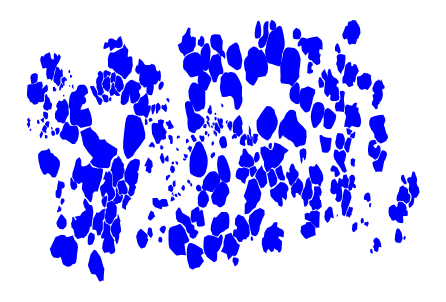

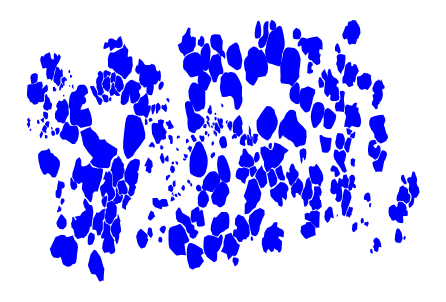

In [31]:
prepare_mask("ZK21", FULL_DATA_PATH, add_bboxes=False, show_image_in_background=False)

In [35]:
def create_mask_array(tile_name, tiles_path):
  img_path = os.path.join(tiles_path, "img", tile_name+".tif")
  #print(img_path)
  img_array = gdal.Open(img_path).ReadAsArray()
  if len(list(img_array.shape)) == 3:
    img_array = img_array[0]
  mask_array = np.zeros(img_array.shape)
  nr, nc = img_array.shape
  gjFeatures = gj['features']
  for gjFi in gjFeatures:
    #print(gjFi)
    if gjFi['geometry']!=None and gjFi['geometry']['coordinates']!=[]:
      coord =  np.array(gjFi['geometry']['coordinates'][0])
      # put mask on the image
      #for seg in coord:
      x_list = coord[:,0]
      y_list = coord[:,1]
      xycrop = np.vstack((x_list, y_list)).T
      ygrid, xgrid = np.mgrid[:nr, :nc]
      xypix = np.vstack((xgrid.ravel(), ygrid.ravel())).T
      # construct a Path from the vertices
      pth = Path(xycrop, closed=False)
      # test which pixels fall  within the path
      mask = pth.contains_points(xypix)
      # reshape to the same size as the image
      mask = mask.reshape(img_array.shape)
      mask_array = np.logical_or(mask_array, mask)
  return mask_array

In [37]:
mask_array = create_mask_array("ZK21", FULL_DATA_PATH)

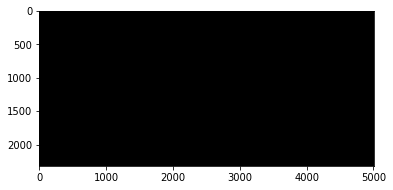

In [38]:
plt.imshow(mask_array, cmap='gray')
plt.show()